[View in Colaboratory](https://colab.research.google.com/github/mingchang0804/python_notebook/blob/master/crawler_new.ipynb)

In [1]:
!pip install BeautifulSoup4
!pip install urllib3

In [0]:
import urllib3
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
import matplotlib.pyplot as plt
from google.colab import files

In [0]:
# library

In [0]:
# download data from website
def get_data(company):
  url = "http://h1bdata.info/index.php?em=" + company + "&job=&year=All+Years"
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  data = soup.find_all("td")
  data_string = []

  for i in range(0, len(data)):
    data_string.append(data[i].get_text())
  
  data_string = np.array(data_string)
  data_table = np.reshape(data_string, (-1,7))
  data_table = pd.DataFrame(data_table,columns=["employer","title","salary","location","submit_date","start_date","case_status"])

  # format salary
  salary_str = data_table.salary.tolist()
  salary_int = [int(s.replace(',', '')) for s in salary_str]
  data_table.salary = salary_int

  # format date
  data_table.submit_date = pd.to_datetime(data_table.submit_date, format='%m/%d/%Y')
  data_table.start_date = pd.to_datetime(data_table.start_date, format='%m/%d/%Y')
  
  return(data_table)

# clean up job titles
def clean_titles():
  new_titles = []

  for i in range(0, len(full_data)):
    old_title = full_data.title[i]
    new_title = "OTHER"

    if "ENGINEER" in old_title or "DEVELOPER" in old_title:
      new_title = "ENGINEER"

    if ("PRODUCT MANAGER" in old_title) or ("PROGRAM MANAGER" in old_title and full_data.employer[i] == "MICROSOFT CORPORATION"):
      new_title = "PRODUCT MANAGER" 

    if "RESEARCH SCIENTIST" in old_title:
      new_title = "RESEARCH SCIENTIST"
          
    if ("QUANTITATIVE ANALYST" in old_title) or ("DATA SCIENTIST" in old_title) \
       or ("BUSINESS ANALYST" in old_title) or ("BUSINESS INTELLIGENCE ANALYST" in old_title) \
       or ("BUSINESS ANALYTICS" in old_title) or ("DATA ANALYST" in old_title) \
       or ("DATA ANALYTICS" in old_title) or ("ANALYTICS" in old_title):
      new_title = "BUSINESS ANALYST"   
    new_titles.append(new_title)
  full_data["new_title"] = new_titles  
    
# is job entry level
def seniority():
  levels = []

  for i in range(0, len(full_data)):
    old_title = full_data.title[i]
    level = "Entry"
    
    if ("SENIOR" in old_title) or ("MANAGER" in old_title) or ("LEAD" in old_title) \
       or ("HEAD" in old_title) or ("DIRECTOR" in old_title):
      level = "Senior"
        
    levels.append(level)
  full_data["seniority"] = levels
  
  
# bucketize salary
def bucketize_salary():
  new_salaries = []
  for i in range(0, len(full_data)):
    salary = full_data.salary[i]
    lower_bound = int(salary/10000)*10
    upper_bound = int(salary/10000)*10 + 10
    new_salary = "$" + str(lower_bound) + "k-" + str(upper_bound) + "k"
    new_salaries.append(new_salary)
  full_data["salary_bucket"] = new_salaries

In [0]:
# 上市公司 （FLAG）
FB = get_data("FACEBOOK")
LNKD = get_data("Linkedin")
AMZN = pd.concat([get_data("AMAZON+CORPORATE+LLC"), get_data("AMAZONCOM+SERVICES+INC"), get_data("AMAZON+WEB+SERVICES+INC"), get_data("AMAZON+FULFILLMENT+SERVICES+INC")])
GOOG = pd.concat([get_data("GOOGLE+LLC"), get_data("GOOGLE+INC")])

# 上市公司（其他）
MS = get_data("MICROSOFT+CORPORATION")
AAPL = get_data("Apple+Inc")
NFLX = get_data("NETFLIX+INC")
TWIT = get_data("TWITTER+INC")
SNAP = get_data("SNAP+INC")

# 小公司
UBER = get_data("Uber+Technologies+Inc")
AIRBNB = get_data("Airbnb+Inc")
PINTEREST = get_data("PINTEREST+INC")
LYFT = get_data("LYFT+INC")
ROBIN = get_data("ROBINHOOD+MARKETS+INC")

In [0]:
full_data = pd.concat([GOOG, FB, LNKD, AMZN, UBER, AIRBNB, MS, AAPL, PINTEREST, LYFT, NFLX, TWIT, SNAP, ROBIN], axis=0).reset_index(drop=True)

In [11]:
np.unique(full_data.employer)

array(['Airbnb', 'Amazon', 'Apple', 'Facebook', 'Google', 'Linkedin',
       'Lyft', 'Microsoft', 'Netflix', 'Pinterest', 'Robinhood',
       'Snapchat', 'Twitter', 'Uber'], dtype=object)

In [0]:
clean_titles()
seniority()
bucketize_salary()

In [0]:
# get year
submit_date = full_data.submit_date.tolist()
year = [date.year for date in submit_date]
full_data['submit_year'] = year

# get month
submit_date = full_data.submit_date.tolist()
month = [date.month for date in submit_date]
full_data['submit_month'] = month

# get state
location = full_data.location.tolist()
state = [l[-2:] for l in location]
full_data['location_state'] = state

# google
full_data['employer'][full_data['employer'] == "GOOGLE INC"] = "Google"
full_data['employer'][full_data['employer'] == "GOOGLE LLC"] = "Google"

# facebook
full_data['employer'][full_data['employer'] == "FACEBOOK INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK MIAMI INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK PAYMENTS INC"] = "Facebook"
full_data['employer'][full_data['employer'] == "FACEBOOK SERVICES INC"] = "Facebook"

# amazon
full_data['employer'][full_data['employer'] == "AMAZON CORPORATE LLC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZONCOM SERVICES INC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZON WEB SERVICES INC"] = "Amazon"
full_data['employer'][full_data['employer'] == "AMAZON FULFILLMENT SERVICES INC"] = "Amazon"

# other
full_data['employer'][full_data['employer'] == "AIRBNB INC"] = "Airbnb"
full_data['employer'][full_data['employer'] == "LINKEDIN CORPORATION"] = "Linkedin"
full_data['employer'][full_data['employer'] == "APPLE INC"] = "Apple"
full_data['employer'][full_data['employer'] == "LYFT INC"] = "Lyft"
full_data['employer'][full_data['employer'] == "UBER TECHNOLOGIES INC"] = "Uber"
full_data['employer'][full_data['employer'] == "MICROSOFT CORPORATION"] = "Microsoft"
full_data['employer'][full_data['employer'] == "PINTEREST INC"] = "Pinterest"
full_data['employer'][full_data['employer'] == "TWITTER INC"] = "Twitter"
full_data['employer'][full_data['employer'] == "NETFLIX INC"] = "Netflix"
full_data['employer'][full_data['employer'] == "ROBINHOOD MARKETS INC"] = "Robinhood"
full_data['employer'][full_data['employer'] == "SNAP INC"] = "Snapchat"

In [12]:
full_data.head()

,employer,title,salary,location,submit_date,start_date,case_status,new_title,seniority,salary_bucket,submit_year,submit_month,location_state
0,Google,1615.29860,115000,"KIRKLAND, WA",2018-01-26,2018-07-25,WITHDRAWN,OTHER,Entry,$110k-120k,2018,1,WA
1,Google,1615.34491,93000,"MOUNTAIN VIEW, CA",2017-11-28,2018-01-22,DENIED,OTHER,Entry,$90k-100k,2017,11,CA
2,Google,1615.34491,93000,"MOUNTAIN VIEW, CA",2017-12-07,2018-01-22,WITHDRAWN,OTHER,Entry,$90k-100k,2017,12,CA
3,Google,ACCOUNT MANAGER (1615.36810),80500,"CAMBRIDGE, MA",2018-03-21,2018-09-20,CERTIFIED,OTHER,Senior,$80k-90k,2018,3,MA
4,Google,ACCOUNT MANAGER 1615.10639,77500,"ANN ARBOR, MI",2018-02-16,2018-07-30,CERTIFIED,OTHER,Senior,$70k-80k,2018,2,MI


In [0]:
# 申请数量对比

In [0]:
# 画图
import matplotlib.style as style
style.use('fivethirtyeight')
my_data = full_data

In [0]:
my_data = my_data[(my_data["new_title"] == "BUSINESS ANALYST")]
my_data = my_data[(my_data["submit_year"] >= 2014) & (my_data["submit_year"] <= 2018)]
my_data = my_data[(my_data["submit_month"] >= 1) & (my_data["submit_month"] <= 3)]
my_data = my_data[(my_data["case_status"] == "CERTIFIED")]

In [0]:
ba_data = my_data[(my_data["new_title"] == "BUSINESS ANALYST")]
ba_opening = ba_data.groupby(["submit_year","employer"])[["salary"]].count().reset_index()
my_pivot_table = ba_opening.pivot(index='submit_year', columns="employer").reset_index()

In [16]:
companies = my_data[(my_data["submit_year"] == 2018)].groupby(["employer"])["salary"].count().reset_index().sort_values(["salary"], ascending=False)["employer"].tolist()
companies

['Google',
 'Amazon',
 'Microsoft',
 'Facebook',
 'Apple',
 'Linkedin',
 'Uber',
 'Lyft',
 'Airbnb',
 'Twitter',
 'Snapchat',
 'Pinterest',
 'Netflix',
 'Robinhood']

In [0]:
# 我们把公司分分类
# 第一类：市值大上市公司
big_guys = ['Google','Amazon', 'Microsoft', 'Facebook', 'Apple','Linkedin','Netflix','Snapchat', 'Twitter']
#
# 第二类：市值小上市公司
# 第三类：独角兽
unicorns = ['Uber', 'Lyft','Airbnb', 'Pinterest']

In [32]:
len(big_guys)

6

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


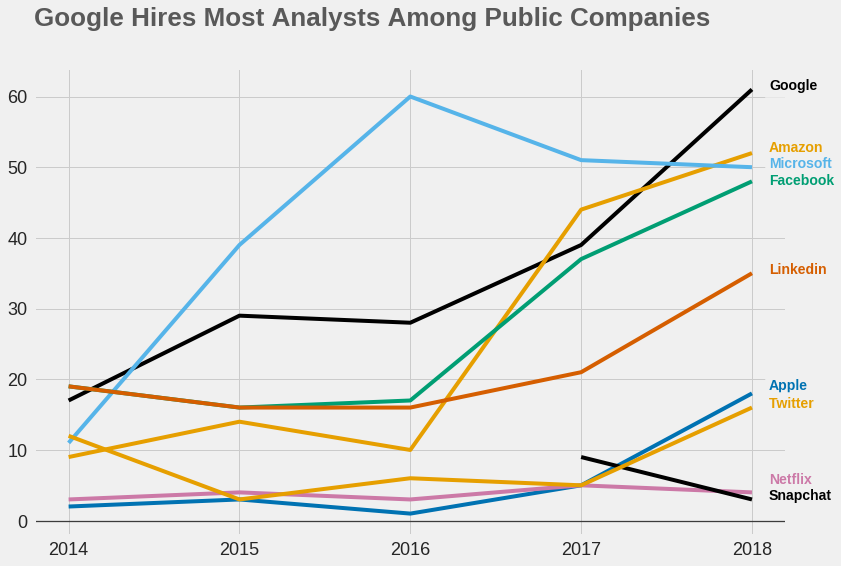

In [62]:
# Colorblind-friendly colors
# https://www.dataquest.io/blog/making-538-plots/
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [0,114/255,178/255], [213/255,94/255,0], [204/255, 121/255, 167/255]]

colors = colors + colors

companies = my_data[(my_data["submit_year"] == 2018)].groupby(["employer"])["salary"].count().reset_index().sort_values(["salary"], ascending=False)["employer"].tolist()

fte_graph = my_pivot_table.salary.plot(x=my_pivot_table.submit_year, y=big_guys, figsize = (12,8), color=colors, legend = False)
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
fte_graph.set_xticks([2014, 2015, 2016, 2017, 2018], minor=False)
fte_graph.xaxis.label.set_visible(False)
fte_graph.set_xlim(left = 2013.8, right = 2018.2)


# 加标题
fte_graph.text(x = 2013.8, y = 70, s = "Google Hires Most Analysts Among Public Companies", fontsize = 26, weight = 'bold', alpha = .75)
#fte_graph.text(x = 2013.5, y = 3700, s = 'Subtitle ', fontsize = 19, alpha = .85)


# 加标记
for i in range(0,len(big_guys)):
  if i == 1:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 0.2, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 
  elif i == 3:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] - 0.5, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 
  elif i == 4:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 0.5, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0')     
  elif i == 6:
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4] + 1.2, s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0')         
  else:  
    fte_graph.text(x = 2018.1, y = my_pivot_table.salary[big_guys[i]][4], s = big_guys[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


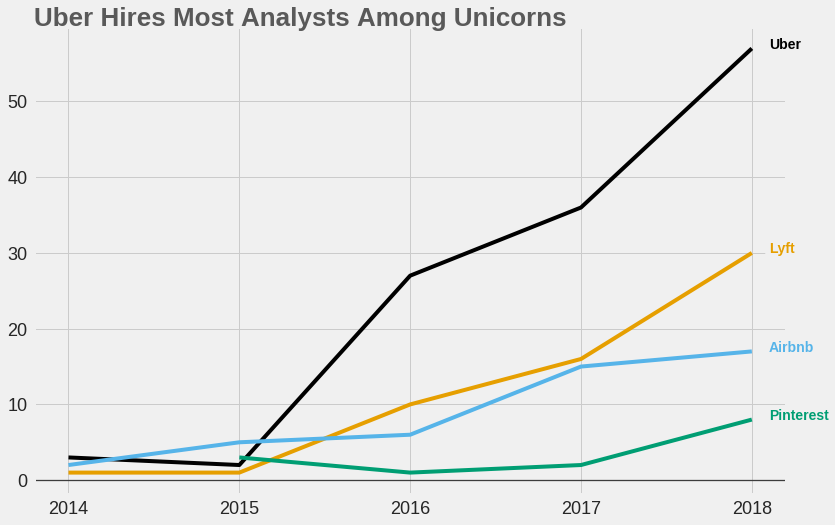

In [69]:
# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [0,114/255,178/255], [213/255,94/255,0], [204/255, 121/255, 167/255]]

fte_graph = my_pivot_table.salary.plot(x=my_pivot_table.submit_year, y=unicorns, figsize = (12,8), color=colors, legend = False)
fte_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
fte_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
fte_graph.set_xticks([2014, 2015, 2016, 2017, 2018], minor=False)
fte_graph.xaxis.label.set_visible(False)
fte_graph.set_xlim(left = 2013.8, right = 2018.2)

# 加标题
fte_graph.text(x = 2013.8, y = 60, s = "Uber Hires Most Analysts Among Unicorns", fontsize = 26, weight = 'bold', alpha = .75)
#fte_graph.text(x = 2013.5, y = 3700, s = 'Subtitle ', fontsize = 19, alpha = .85)


# 加标记
for i in range(0,len(unicorns)):
  fte_graph.text(x = 2018.1, y = my_pivot_table.salary[unicorns[i]][4], s = unicorns[i], color = colors[i], weight = 'bold', backgroundcolor = '#f0f0f0') 

In [0]:
# average salary

In [73]:
np.unique(my_data.new_title)

array(['BUSINESS ANALYST'], dtype=object)

In [74]:
my_data.head()

,employer,title,salary,location,submit_date,start_date,case_status,new_title,seniority,salary_bucket,submit_year,submit_month,location_state
79,Google,ASSOCIATE BUSINESS INTELLIGENCE ANALYST (1615...,76000,"SUNNYVALE, CA",2018-02-15,2018-07-24,CERTIFIED,BUSINESS ANALYST,Entry,$70k-80k,2018,2,CA
92,Google,BUSINESS ANALYST (1615.35902),108000,"MOUNTAIN VIEW, CA",2018-01-02,2018-01-09,CERTIFIED,BUSINESS ANALYST,Entry,$100k-110k,2018,1,CA
93,Google,BUSINESS ANALYST (1615.37484),130000,"MOUNTAIN VIEW, CA",2018-03-01,2018-03-08,CERTIFIED,BUSINESS ANALYST,Entry,$130k-140k,2018,3,CA
94,Google,BUSINESS ANALYST (1615.37835),140000,"SUNNYVALE, CA",2018-03-16,2018-03-26,CERTIFIED,BUSINESS ANALYST,Entry,$140k-150k,2018,3,CA
95,Google,BUSINESS ANALYST 1615.25693,112000,"MOUNTAIN VIEW, CA",2018-01-10,2018-07-09,CERTIFIED,BUSINESS ANALYST,Entry,$110k-120k,2018,1,CA


In [0]:
# create a vector of arrays
titles = ["BUSINESS ANALYST","ENGINEER","PRODUCT MANAGER"]
my_array = [np.array(my_data[my_data["new_title"] == title]["salary"]) for title in titles]

In [69]:
my_array

[array([ 76000, 108000, 130000, ..., 125000, 125000, 180000]),
 array([120000, 108000, 108000, ..., 200000, 210000, 135000]),
 array([120000, 120000, 140000, ..., 180000, 185000, 185000])]

Text(200000,3.2,'Product Manager: $131,457')

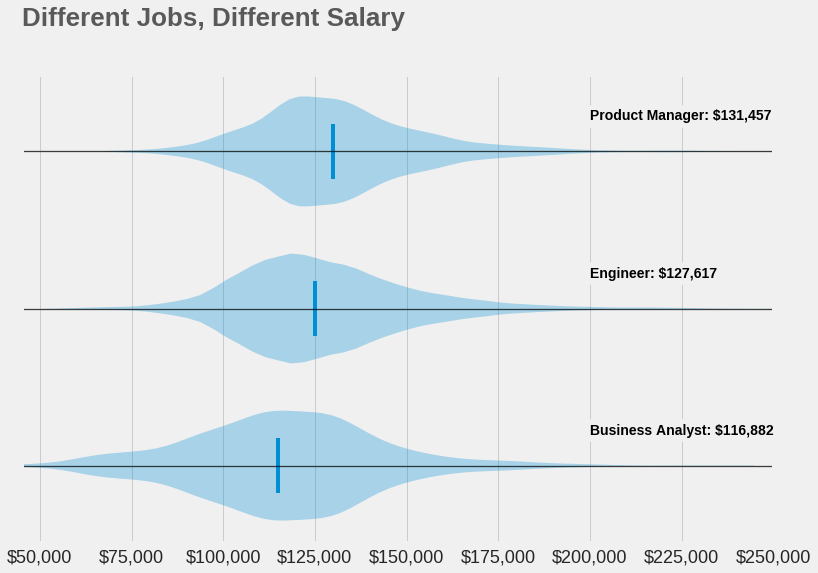

In [71]:
# 不同职位工资对比
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 8))
pos = [1,2,3]
ax.violinplot(my_array, pos, points=80, vert=False, widths=0.7, showmeans=False, showextrema=False, showmedians=True)

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [0,114/255,178/255], [213/255,94/255,0], [204/255, 121/255, 167/255]]


ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.axhline(y = 1, color = 'black', linewidth = 1.3, alpha = .7)
ax.axhline(y = 2, color = 'black', linewidth = 1.3, alpha = .7)
ax.axhline(y = 3, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_yticks([1, 2, 3], minor=False)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(True)
ax.set_yticklabels([])
ax.set_xlim(left=45000, right = 250000)

# 美元符号
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 


# 加标题
ax.text(x = 45000, y = 3.8, s = "Different Jobs, Different Salary", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
ax.text(x = 200000, y = 1.2, s = 'Business Analyst: '+'${:,.0f}'.format(np.average(my_array[0])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')
ax.text(x = 200000, y = 2.2, s = 'Engineer: '+'${:,.0f}'.format(np.average(my_array[1])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')
ax.text(x = 200000, y = 3.2, s = 'Product Manager: '+'${:,.0f}'.format(np.average(my_array[2])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')

In [11]:

my_data.head()

,Unnamed: 0,employer,title,salary,location,submit_date,start_date,case_status,new_title,seniority,salary_bucket,submit_year,submit_month,location_state
71,71,Google,ADS SOLUTIONS ENGINEER,120000,"NEW YORK, NY",2015-10-01,2015-11-09,CERTIFIED,ENGINEER,Entry,$120k-130k,2015,10,NY
77,77,Google,ALGORITHM ENGINEER,105000,"PALO ALTO, CA",2014-03-17,2014-09-12,CERTIFIED,ENGINEER,Entry,$100k-110k,2014,3,CA
109,109,Google,ANALYTICS MANAGER 1615.10021,118000,"MOUNTAIN VIEW, CA",2017-02-06,2017-08-01,CERTIFIED,BUSINESS ANALYST,Senior,$110k-120k,2017,2,CA
110,110,Google,ANALYTICS PROGRAM MANAGER,100000,"MOUNTAIN VIEW, CA",2014-02-11,2014-07-23,CERTIFIED,BUSINESS ANALYST,Senior,$100k-110k,2014,2,CA
113,113,Google,ANTI-ABUSE ENGINEER,88000,"MOUNTAIN VIEW, CA",2015-02-18,2015-08-17,CERTIFIED,ENGINEER,Entry,$80k-90k,2015,2,CA


In [0]:
# salary comparison among companies
ba_salary = my_data[my_data["new_title"] == "BUSINESS ANALYST"].groupby(["employer"])["salary"].median().reset_index().sort_values(by=["salary"],ascending=False)
salary_count = my_data[my_data["new_title"] == "BUSINESS ANALYST"].groupby(["employer"])["salary"].count()
#companies = ba_salary.employer.tolist()

In [0]:
companies = ['Netflix',
 'Airbnb',
 'Lyft',
 'Facebook',
 'Twitter',
 'Google',
 'Pinterest',
 'Microsoft',
 'Linkedin',
 'Apple',
 'Uber',
 'Amazon',
 'Snapchat']

my_array = [np.array(my_data[(my_data["employer"] == c) & (my_data["new_title"] == "BUSINESS ANALYST")]["salary"]) for c in companies]

In [94]:
my_array[0]
my_array[1]


array([103615, 108000, 180000, 130000, 120000, 123000, 128000, 128000,
       128000, 128000, 130000, 130000, 130000, 130000, 135000, 135000,
       135000, 135000, 140000, 140000, 140000, 144382, 145000, 145000,
       145000, 148150, 150000, 160000, 160000, 160058, 170000, 170000,
       175723, 178541, 190000, 150000, 150000, 150000, 150000, 135000,
       185000, 135000, 192400, 150000, 175000])

In [0]:
for i in range(13,1):
  print(i)

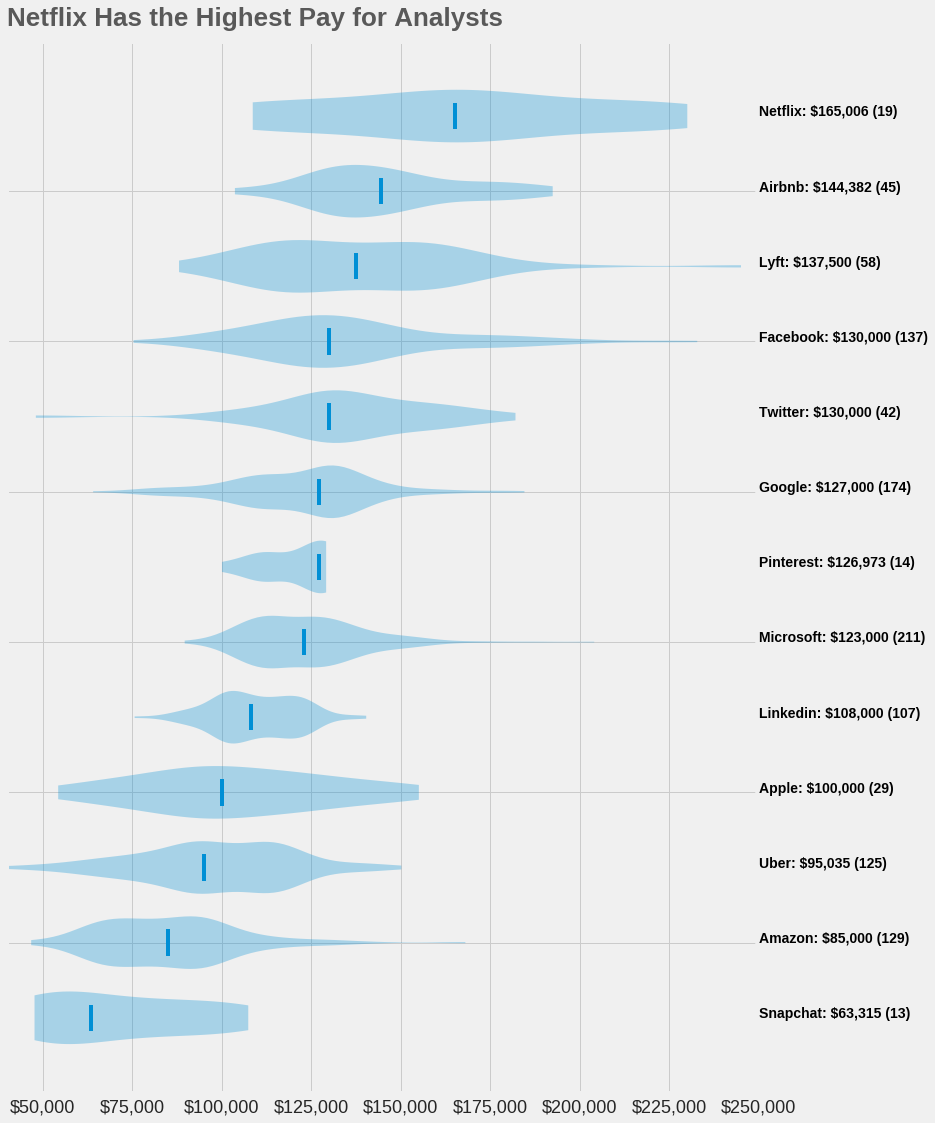

In [103]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 18))
pos = [13,12,11,10,9,8,7,6,5,4,3,2,1]
ax.violinplot(my_array, pos, points=80, vert=False, widths=0.7, showmeans=False, showextrema=False, showmedians=True)

ax.tick_params(axis = 'both', which = 'both', labelsize = 18)
#ax.axhline(y = i, color = 'black', linewidth = 1.3, alpha = .7)   
ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12,13], minor=True)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(True)
ax.set_yticklabels([])
ax.set_xlim(left=40000, right = 250000)

# 美元符号
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 


# 加标题
ax.text(x = 40000, y = 14.2, s = "Netflix Has the Highest Pay for Analysts", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
for i in range(1,len(companies)+1):
  company = companies[-i]
#  company_count = salary_count[company]
  median_salary = np.median(my_array[-i])
  salary_count = np.count_nonzero(my_array[-i])
  ax.text(x = 250000, y = i, s = companies[-i] + ': ' + '${:,.0f}'.format(median_salary) + ' (' + str(salary_count) + ')', color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')

In [0]:
# uber amazon salary very low, what happened

In [105]:
uber_data = my_data[(my_data["employer"] == "Lyft") & (my_data["new_title"] == "BUSINESS ANALYST")]
company_salary = uber_data.groupby(["title"])[["salary"]].median().reset_index().sort_values(["salary"], ascending=False)
company_salary

,title,salary
7,HEAD OF ANALYTICS,245000
6,DIRECTOR BRAND ANALYTICS,200000
0,ANALYTICS MANAGER,155000
5,DATA SCIENTIST,155000
8,QUANTITATIVE DATA ANALYST,135000
9,SENIOR DATA ANALYST,125000
1,ASSOC MANAGER FRAUD AND RISK ANALYTICS,120000
4,DATA ANALYTICS,120000
3,DATA ANALYST,115000
2,ASSOC. MANAGER PAYMENT OPERATIONS ANALYTICS,88000


In [0]:
# salary among different states

In [28]:
states = ["CA","NY","WA"]
location_data = my_data[(my_data["new_title"] == "BUSINESS ANALYST")]
location_data = location_data[(location_data["location_state"] == "NY") | (location_data["location_state"] == "CA") | (location_data["location_state"] == "WA")]
location_salary = location_data.groupby(["location_state"])[["salary"]].median().sort_values(["salary"], ascending=False).reset_index()
location_salary

,location_state,salary
0,NY,126500
1,CA,120000
2,WA,112500


Text(200000,3.2,'Seattle: $123,252')

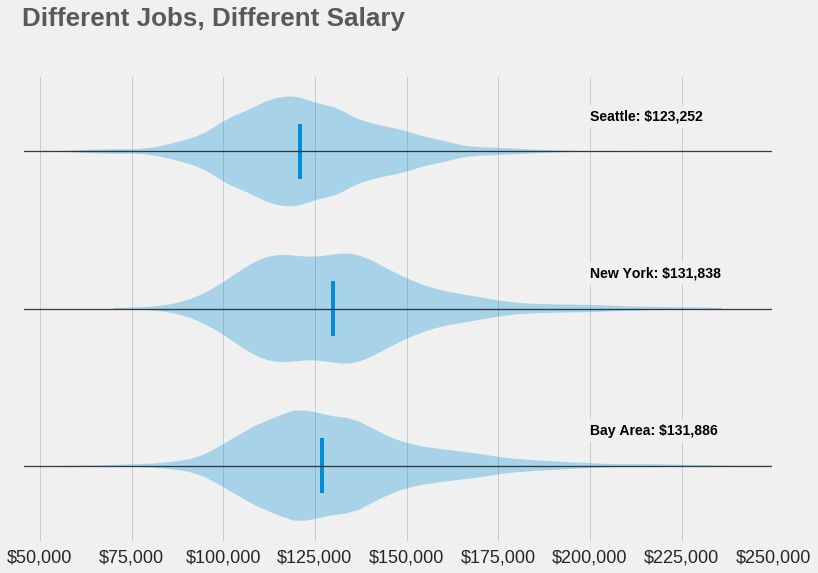

In [27]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(12, 8))
pos = [1,2,3]
ax.violinplot(my_array, pos, points=80, vert=False, widths=0.7, showmeans=False, showextrema=False, showmedians=True)

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [0,114/255,178/255], [213/255,94/255,0], [204/255, 121/255, 167/255]]


ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
ax.axhline(y = 1, color = 'black', linewidth = 1.3, alpha = .7)
ax.axhline(y = 2, color = 'black', linewidth = 1.3, alpha = .7)
ax.axhline(y = 3, color = 'black', linewidth = 1.3, alpha = .7)
ax.set_yticks([1, 2, 3], minor=False)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(True)
ax.set_yticklabels([])
ax.set_xlim(left=45000, right = 250000)

# 美元符号
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 


# 加标题
ax.text(x = 45000, y = 3.8, s = "Different Jobs, Different Salary", fontsize = 26, weight = 'bold', alpha = .75)


# 加标记
ax.text(x = 200000, y = 1.2, s = 'Bay Area: '+'${:,.0f}'.format(np.average(my_array[0])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')
ax.text(x = 200000, y = 2.2, s = 'New York: '+'${:,.0f}'.format(np.average(my_array[1])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')
ax.text(x = 200000, y = 3.2, s = 'Seattle: '+'${:,.0f}'.format(np.average(my_array[2])), color = colors[0], weight = 'bold', backgroundcolor = '#f0f0f0')